In [201]:
from model import OrientationWei, vonmises180, vonmises180_sample
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import simpson
import numpy as np
from scipy.interpolate import UnivariateSpline, interp1d

In [204]:
model = OrientationWei()

We start with some $\theta_0$ for which we want to estimate a _distribution_ of estimates of the subject $\hat{\theta}$: 

$p(\hat{\theta}|\theta_0)$

In [224]:
theta0 = .2*np.pi
theta0_ = model.stim2rep(theta0)

We also have a noise term $\sigma$ that steers the noisiness of the likelihood in sensory sapce

In [225]:
sigma_rep = 0.05

First, we estimate how likely different sensory measurements $m$ are for the given $\theta_0$

In [226]:
pm = vonmises180(theta0_, sigma_rep, model.rep_grid)

Our strategy is now as follows: for each m that we have, we are going to calculate what the subject's best estimate of $\theta$, is, namely the expected value $E[\theta]$, or $\hat{\theta}$ (Equation 11 in Wei & Stocker).

In [227]:
theta_est_ = model.subject_estimate_theta(model.rep_grid, sigma_rep=sigma_rep)
theta_est = interp1d(model.rep_grid, theta_est_, fill_value='extrapolate', bounds_error=False)

Now, we have a distribution of $m$ s, as well as their corresponding estimates. This lookup-table is basically a _transfer function_ $f(m) -> \theta$, that transfers measurements $m$ to the stimulus space $\theta$.



However, since $m$ is a _random variable_ we have to use the gradient of that transfer function $f'(m)$ to correct for contractions and expansions of the probability density. We can just estimate that as a lookup-table as well

In [228]:
theta_est_dx_ = np.gradient(theta_est_.squeeze(), model.rep_grid)
theta_est_dx = interp1d(model.rep_grid, theta_est_dx_, fill_value='extrapolate', bounds_error=False)

To get the density function of $p(\theta)$, we just have to do

$p(\hat{\theta}|\theta_0) = \frac{p(m|\theta_0)}{f'(m)}$

In [229]:
ptheta = pm/theta_est_dx(model.rep_grid)

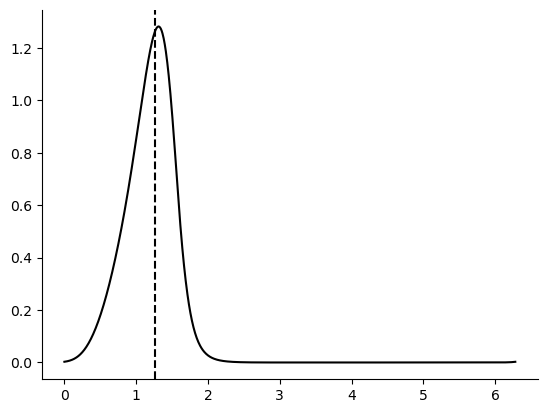

In [230]:
plt.plot(model.stim_grid_, ptheta, color='k')
sns.despine()
plt.axvline(theta0, c='k', ls='--')

To check whether this all makes sense, we are going to simulate a bunch of $m$ s and estimate their corresponding $\hat{\theta}$ s (blue), and overlay the estimated density function (orange)

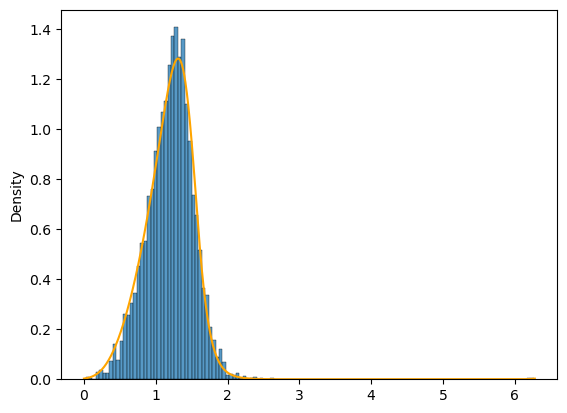

In [242]:
# For a given theta0, gets converted it to sensory space and then can have different posssible sensory representation coming from vonmises
samples_m = vonmises180_sample(theta0_, sigma_rep, 5000)

# Subject estimates a given posterior estimate for each m from this vonmises
estimates = model.subject_estimate_theta(np.array(samples_m), sigma_rep)

sns.histplot(estimates.squeeze(), stat='density')
plt.plot(model.stim_grid_, ptheta, color='orange')

In [243]:
from ipywidgets import interact

In [248]:
# @interactive(theta0=(0, np.pi*2.), sigma_rep=(0, 1))
def plot_estimate_distribution(theta0, sigma_rep, simulation=True):
    theta0_ = model.stim2rep(theta0)
    pm = vonmises180(theta0_, sigma_rep, model.rep_grid)
    theta_est_ = model.subject_estimate_theta(model.rep_grid, sigma_rep=sigma_rep)
    # theta_est = interp1d(model.rep_grid, theta_est_, fill_value='extrapolate', bounds_error=False)
    theta_est_dx_ = np.gradient(theta_est_.squeeze(), model.rep_grid)
    theta_est_dx = interp1d(model.rep_grid, theta_est_dx_, fill_value='extrapolate', bounds_error=False)
    ptheta = pm/theta_est_dx(model.rep_grid)



    if simulation:
        samples_m = vonmises180_sample(theta0_, sigma_rep, 5000)

        # Subject estimates a given posterior estimate for each m from this vonmises
        estimates = model.subject_estimate_theta(np.array(samples_m), sigma_rep)

        sns.histplot(estimates.squeeze(), stat='density')

    plt.plot(model.stim_grid_, ptheta, color='orange')
    sns.despine()
    plt.axvline(theta0, c='orange', ls='--')

interact(plot_estimate_distribution, theta0=(0, np.pi*2.), sigma_rep=(0.01, 1),
simulation=(False, True))


interactive(children=(FloatSlider(value=3.141592653589793, description='theta0', max=6.283185307179586), Float…

<function __main__.plot_estimate_distribution(theta0, sigma_rep, simulation=True)>